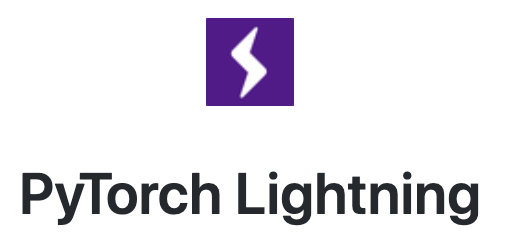

# ALBERT for Question Answering

We are using a tensor model on top of ALBERT for the SQUAD 2.0 dataset


## Setup  
First, let's check the GPU we got. If memory < 11GB, I'd suggest to do factory reset runtime. Ideally, try to get 16GB

In [39]:
!nvidia-smi

Fri Nov 27 13:41:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Installing all necessary libraries -- Pytorch Lightning, transformers and tensorflow

In [ ]:
%tensorflow_version 1.x
!pip install -q pytorch-lightning
!pip install -q transformers

TensorFlow 1.x selected.
     |████████████████████████████████| 563kB 6.7MB/s 
     |████████████████████████████████| 829kB 10.6MB/s 
     |████████████████████████████████| 276kB 17.7MB/s 
     |████████████████████████████████| 10.6MB 19.6MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 1.15.2 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.4.0 which is incompatible.
     |████████████████████████████████| 1.3MB 6.5MB/s 
     |████████████████████████████████| 1.1MB 12.2MB/s 
     |████████████████████████████████| 2.9MB 24.9MB/s 
     |████████████████████████████████| 890kB 44.7MB/s 


Some more importing

In [44]:
import os
import pickle, json
import numpy as np
from tqdm import tqdm, trange
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader, random_split
import pytorch_lightning as pl
from transformers import AlbertModel, AlbertTokenizer

## Data download 

Mount the drive to get access to reading and writing files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'ybshmmlchk/zatoboj/SQUAD/'

Mounted at /content/gdrive


#### Loading preprocessed data. For the preprocessing part -- see Albert_Preprocessing.ipynb


In [ ]:
# load train dataset
with open(root_dir + 'ybshmmlchk/albert256_train.pickle', 'rb') as f:
    train_data = pickle.load(f)
    
input_ids = train_data["input_ids"]
token_type_ids = train_data["token_type_ids"]
labels = train_data["labels"]
attention_mask = train_data["attention_mask"]
answer_mask = train_data['answer_mask']
plausible_answer_mask = train_data['plausible_answer_mask']
full_answers = train_data['full_answers']
full_questions = train_data['full_questions']
full_paragraphs = train_data['full_paragraphs']
indexing = list(range(0, len(labels)))
print('Number of train input ids:'.ljust(30), len(input_ids))
# print('Number of train token type ids:'.ljust(30), len(token_type_ids))
# print('Number of train labels:'.ljust(30), len(labels))

Number of input ids:           111281
Number of token type ids:      111281
Number of labels:              111281


In [ ]:
# load test dataset
with open(root_dir + 'ybshmmlchk/albert256_test.pickle', 'rb') as f:
    test_data = pickle.load(f)
    
test_input_ids = test_data["input_ids"]
test_token_type_ids = test_data["token_type_ids"]
test_labels = test_data["labels"]
test_attention_mask = test_data["attention_mask"]
test_answer_mask = test_data['answer_mask']
test_plausible_answer_mask = test_data['plausible_answer_mask']
test_full_answers = test_data['full_answers']
test_full_questions = test_data['full_questions']
test_full_paragraphs = test_data['full_paragraphs']
test_indexing = list(range(0, len(test_labels)))
print('Number of input ids:'.ljust(30), len(test_input_ids))

Number of input ids:           5296


The fraction of unanswerable questions is about 33%, so about 66% have an answer. The average number of tokens that are in the answer is about 1%. Since the length of our "sentences" is 256, the average length of answers is about 3 tokens.

In [ ]:
print('Fraction of unaswerable questions:', np.mean(labels))
print('Average fraction of answer tokens in paragraph:',np.array([np.array(x).mean() for x in answer_mask]).mean())

Fraction of unaswerable questions: 0.3361939594360223
Average fraction of answer tokens in paragraph: 0.011225874700083573


Here is an example of an entry in the dataset. Note that the "answer" is a plausible answer, not the actual answer, which is showed by label=True.

In [ ]:
i = 153
print('Input id:', i)
print('Question:', full_questions[i])
print('Answer:', full_answers[i])
print('Paragraph:', full_paragraphs[i])
print('Label:', labels[i]) 

Input id: 153
Question: What did the UN Peacebuliding Commission decide on Jan 8, 2008?
Answer: the Central African Republic was eligible to receive assistance from the Peacebuilding Fund
Paragraph: In 2006, due to ongoing violence, over 50,000 people in the country's northwest were at risk of starvation but this was averted due to assistance from the United Nations.[citation needed] On 8 January 2008, the UN Secretary-General Ban Ki-Moon declared that the Central African Republic was eligible to receive assistance from the Peacebuilding Fund. Three priority areas were identified: first, the reform of the security sector; second, the promotion of good governance and the rule of law; and third, the revitalization of communities affected by conflicts. On 12 June 2008, the Central African Republic requested assistance from the UN Peacebuilding Commission, which was set up in 2005 to help countries emerging from conflict avoid devolving back into war or chaos.
Label: True


Helper functions to distinguish actual answers from plausible answers

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v1')

In [ ]:
# return a tokenized actual answer or None
def get_actual_ans(i):
  return get_answer(input_ids[i], answer_mask[i])

# return a tokenized plausible answer
def get_plaus_ans(i):
  return get_answer(input_ids[i], plausible_answer_mask[i])

# helper function to get an answer
def get_answer(input_id, answer):
  indices = (np.nonzero(answer)[0]).tolist()
  if indices:
    tokens = tokenizer.convert_ids_to_tokens(input_id)
    return tokens[indices[0]:indices[-1]+1]
  else:
    return None

In [ ]:
i=22
print('Input id:',i)
print('Plausible answer:'.ljust(27), full_answers[i])
print('Tokenized plausible answer:'.ljust(27), get_plaus_ans(i))
print('Tokenized actual answer:'.ljust(27), get_actual_ans(i))
i=100
print('Input id:',i)
print('Plausible answer:'.ljust(27), full_answers[i])
print('Tokenized plausible answer:'.ljust(27), get_plaus_ans(i))
print('Tokenized actual answer:'.ljust(27), get_actual_ans(i))

Input id: 22
Plausible answer:           1969
Tokenized plausible answer: ['▁1969']
Tokenized actual answer:    None
Input id: 100
Plausible answer:           Beautiful Day
Tokenized plausible answer: ['▁beautiful', '▁day']
Tokenized actual answer:    ['▁beautiful', '▁day']


Now we define a function which will return train and validation dataloaders. The breakdown is 95-5.

In [40]:
def generate_squad_dataloaders(batch_size):
  # ----------------------
  # TRAIN/VAL/TEST DATALOADERS
  # ----------------------

  # TensorDataset from training examples. ".cuda()" puts the corresponding tensor on gpu
  squad_train_dataset = TensorDataset(torch.tensor(input_ids, dtype=torch.long).cuda(),
                                torch.tensor(attention_mask, dtype=torch.long).cuda(),  
                                torch.tensor(token_type_ids, dtype=torch.long).cuda(), 
                                1 - torch.tensor(labels, dtype=torch.long).cuda(), #label is 0 if there is an answer in the original dataset
                                torch.tensor(answer_mask, dtype=torch.long).cuda(),
                                torch.tensor(indexing, dtype=torch.long).cuda())
  
  squad_val_dataset = TensorDataset(torch.tensor(test_input_ids, dtype=torch.long).cuda(),
                                torch.tensor(test_attention_mask, dtype=torch.long).cuda(),  
                                torch.tensor(test_token_type_ids, dtype=torch.long).cuda(), 
                                1 - torch.tensor(test_labels, dtype=torch.long).cuda(), #label is 0 if there is an answer in the original dataset
                                torch.tensor(test_answer_mask, dtype=torch.long).cuda(),
                                torch.tensor(test_indexing, dtype=torch.long).cuda())
  
  # test is not actually used yet
  """squad_test_dataset = TensorDataset(torch.tensor(input_ids[nb_train_samples+nb_val_samples:], dtype=torch.long).cuda(),
                                torch.tensor(attention_mask[nb_train_samples+nb_val_samples:], dtype=torch.long).cuda(),  
                                torch.tensor(token_type_ids[nb_train_samples+nb_val_samples:], dtype=torch.long).cuda(), 
                                1 - torch.tensor(labels[nb_train_samples+nb_val_samples:], dtype=torch.long).cuda(), #label is 0 if there is an answer in the original dataset
                                torch.tensor(answer_mask[nb_train_samples+nb_val_samples:], dtype=torch.long).cuda(),
                                torch.tensor(indexing[nb_train_samples+nb_val_samples:], dtype=torch.long).cuda())"""

  print('Train set size:', len(labels))
  print('Validation set size:', len(test_labels))

  # train loader
  train_sampler = RandomSampler(squad_train_dataset)
  squad_train_dataloader = DataLoader(squad_train_dataset, sampler = train_sampler, batch_size = batch_size)

  # val loader
  val_sampler = RandomSampler(squad_val_dataset)
  squad_val_dataloader = DataLoader(squad_val_dataset, sampler = val_sampler, batch_size = batch_size, shuffle = False)

  # test loader
  #test_sampler = RandomSampler(squad_test_dataset)
  #squad_test_dataloader = DataLoader(squad_test_dataset, sampler=test_sampler, batch_size = batch_size)
 
  return squad_train_dataloader, squad_val_dataloader#, squad_test_dataloader

Defining the model from BERT paper with start and end vector

In [41]:
bert = AlbertModel.from_pretrained('albert-base-v1', output_attentions=True)

In [42]:
# returns start and end of the answer. answer_mask is of shape (batch_size, max_len)
def get_start_end(answer_mask):
    start = torch.argmax(answer_mask, 1, keepdim=False)
    end = torch.argmax(answer_mask, 1, keepdim=False) + answer_mask.sum(dim=1) -1
    end[end==-1] = 0
    return start, end

In [45]:
class SQUADBERT(pl.LightningModule):

    def __init__(self, batch_size):
        super(SQUADBERT, self).__init__()
        # initializing BERT, parameters, dataloaders
        self.bert = bert.cuda()
        self.n = bert.config.hidden_size
        self.max_len = 256
        self.batch_size = batch_size
        self.squad_train_dataloader, self.squad_val_dataloader = generate_squad_dataloaders(self.batch_size)
        # initializing additional layers -- start and end vectors
        self.Start = nn.Linear(self.n, 1)
        self.End = nn.Linear(self.n, 1)

    def new_layers(self, q, new_layer):
        logits_wrong_shape = new_layer(torch.reshape(q, (q.shape[0]*q.shape[1], q.shape[2])))
        logits = torch.reshape(logits_wrong_shape, (q.shape[0], q.shape[1]))
        return logits

    def forward(self, input_ids, attention_mask, token_type_ids):
        #apply BERT
        q, _, attn = self.bert(input_ids=input_ids, 
                         attention_mask=attention_mask, 
                         token_type_ids=token_type_ids)
        # shape of q will be (batch_size, max_len, bert_dim) = (batch_size, 256, 768)
        # take inner products of output vectors with trainable start and end vectors
        start_logits = self.new_layers(q, self.Start)
        end_logits = self.new_layers(q, self.End)

        return start_logits, end_logits

    # this is the main function of pl modules. defines architecture and loss function. training loop comes for free -- implemented inside PL
    def training_step(self, batch, batch_nb):
        # batch
        input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
         
        # fwd
        start_logits, end_logits = self.forward(input_ids, attention_mask, token_type_ids)
        
        # LOSS
        # get start and end positions from answer_mask
        start, end = get_start_end(answer_mask)

        # compute cross_entropy loss between predictions and actual labels for start and end 
        loss1 = F.cross_entropy(start_logits, start)
        loss2 = F.cross_entropy(end_logits, end)
        loss = loss1 + loss2

        self.log('loss', loss, prog_bar=True)
        # logs
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # batch
        input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch

        # fwd
        start_logits, end_logits = self.forward(input_ids, attention_mask, token_type_ids)

        # loss
        start, end = get_start_end(answer_mask)

        loss1 = F.cross_entropy(start_logits, start)
        loss2 = F.cross_entropy(end_logits, end)
        loss = loss1 + loss2

        # ^^^^ the code above is the same as for training step, but we also add accuracy computation for validation below

        # acc
        a, y1 = torch.max(start_logits, dim=1)
        a, y2 = torch.max(end_logits, dim=1)
        
        start_acc = torch.sum(y1 == start) / self.batch_size
        end_acc = torch.sum(y2 == end) / self.batch_size
        self.log('start_acc', start_acc, prog_bar=True)
        self.log('end_acc', end_acc, prog_bar=True)
        return {'val_loss' : loss, 'start_acc' : start_acc, 'end_acc' : end_acc}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        start_acc = torch.stack([x['start_acc'] for x in outputs]).mean()
        end_acc = torch.stack([x['end_acc'] for x in outputs]).mean()

        self.log('validation_loss', avg_loss, prog_bar=True)
        self.log('start_accuracy', start_acc, prog_bar=True)
        self.log('end_accuracy', end_acc, prog_bar=True)
        tensorboard_logs = {'val_loss': avg_loss, 'start_acc' : start_acc, 'end_acc' : end_acc}
        return {'avg_val_loss': avg_loss, 'progress_bar': tensorboard_logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=3e-05, eps=1e-08)

    def train_dataloader(self):
        return self.squad_train_dataloader

    def val_dataloader(self):
        return self.squad_val_dataloader


In [46]:
model = SQUADBERT(32)

Train set size: 111281
Validation set size: 5296


In [57]:
list(dict(bert.named_parameters()).keys())

['embeddings.word_embeddings.weight',
 'embeddings.position_embeddings.weight',
 'embeddings.token_type_embeddings.weight',
 'embeddings.LayerNorm.weight',
 'embeddings.LayerNorm.bias',
 'encoder.embedding_hidden_mapping_in.weight',
 'encoder.embedding_hidden_mapping_in.bias',
 'encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight',
 'encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias',
 'encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight',
 'encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias',
 'encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight',
 'encoder.albert_layer_groups.0.albert_layers.0.attention.key.bias',
 'encoder.albert_layer_groups.0.albert_layers.0.attention.value.weight',
 'encoder.albert_layer_groups.0.albert_layers.0.attention.value.bias',
 'encoder.albert_layer_groups.0.albert_layers.0.attention.dense.weight',
 'encoder.albert_layer_groups.0.albert_layers.0.attention.dense.b

### Trainer
The trainer takes care of putting things in the correct GPU or not.
It handles all the engineering for you (such as automatic early stopping) so you just have to worry about the model and data!

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
bert_finetuner = SQUADBERT(32)
pl.Trainer()
# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(gpus=1, amp_level='O2',precision=16, max_epochs = 2)#, val_check_interval=0.25)#checkpoint_callback=checkpoint_callback, max_nb_epochs = 2val_check_interval=1,)    
trainer.fit(bert_finetuner) 

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name  | Type        | Params
--------------------------------------
0 | bert  | AlbertModel | 11 M  
1 | Start | Linear      | 769   
2 | End   | Linear      | 769   


train, validation size --  110748 5829


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

**Saving**

In [ ]:
model_name = '2epochs_base_albert'
trainer.save_checkpoint(base_dir + 'saved_models/' + model_name)

**Loading**

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
model = SQUADBERT(16)
model_name = '2epochs_base_albert'
checkpoint = torch.load(base_dir + 'saved_models/' + model_name, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

train, validation size --  110748 5829


SQUADBERT(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
          

**Results on validation**

Helper functions

In [ ]:
#returns "probabilities" of start and end. not actually probabilities, because this is before softmax
def predict(model, batch):
  input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
  return model(input_ids, attention_mask, token_type_ids)

# returns start and end vectors, just based on argmax taken individually
def convert_predictions(l1, l2):#, label, answer_mask):
  a, y1 = torch.max(l1, dim=1)
  a, y2 = torch.max(l2, dim=1)
  
  return y1, y2#, guess1, guess2, d_pre, d_post

# returns start and end vectors taking into account that end>=start + start can't be before question end
def convert_predictions_improved(l1, l2, min_start):
  starts, ends = [], []
  for i in range(l1.shape[0]):
    p1, p2 = l1[i], l2[i]
    highest_prob = p1[0] + p2[0]
    start, end = 0, 0
    for k in range(min_start[i], 256):
      for j in range(k, 256):
        if p1[k] + p2[j] > highest_prob:
          highest_prob, start, end = p1[k] + p2[j], k, j
    starts.append(start)
    ends.append(end)
  return torch.Tensor(starts), torch.Tensor(ends)

def npf(tt):
  return tt.detach().cpu().numpy()

def convert_predictions_improved_v3(start_batch, end_batch, min_start=None):
  start_batch, end_batch, min_start = npf(start_batch), npf(end_batch), npf(min_start)
  #start_batch, end_batch = npf(start_batch), npf(end_batch)
  batch_size, max_len = start_batch.shape
  probs = start_batch.reshape(-1,max_len,1) + end_batch.reshape(-1,1,max_len) # array of shape: (batch_size, max_len, max_len), matrix of pairwise sums per each element of the batch
  if min_start is not None:
    mask = np.zeros(probs.shape)  # create a mask to avoid including cases where i > j or i > min_start or j > min_start
    for i,s in enumerate(min_start):
        mask[i,:s,:] = 1
        mask[i,:,:s] = 1
        mask[i][np.tril_indices(max_len,-1)] = 1
    mask[:,0,0] = 0               # we however leave i=j=0 to detect questions without answers
    probs = np.ma.array(probs,mask=mask)
    probs = np.ma.filled(probs,-np.inf)
  else:
    probs = np.triu(probs)
  max_probs = np.argmax(probs.reshape(batch_size,-1), axis=-1) # array of shape: (batch_size,), argmaxes of flattened matrices of pairwise sums
  starts, ends = np.unravel_index(max_probs, (max_len, max_len)) # two arrays of shape: (batch_size,), 'unflattenning' of max_probs
  return starts, ends

Validation itself

In [ ]:
from pprint import pprint
def validate(model):
  #iterator 
  a = (model.val_dataloader())
  #batch = True
  d = {
        'num_examples' : 0,
        'num_starts_guessed' : 0,
        'num_ends_guessed' : 0,
        'num_exact_matches_guessed' : 0,
        'num_starts_guessed_post' : 0,
        'num_ends_guessed_post' : 0,
        'num_exact_matches_guessed_post' : 0
      }
  for batch_ndx, batch in enumerate(a):
    #batch = iterator.next()
    l1, l2 = predict(model, batch)
    y1, y2 = convert_predictions(l1, l2)
    input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
    start, end = get_start_end(answer_mask)
    d['num_examples'] += start.shape[0]
    d['num_starts_guessed'] += torch.sum(start==y1)
    d['num_ends_guessed'] += torch.sum(end==y2)
    d['num_exact_matches_guessed'] += torch.sum(((start==y1).double()  + (end==y2).double() )==2.)
    _ , min_start = torch.max(token_type_ids, dim=1)
    
    y1, y2 = convert_predictions_improved_v3(l1, l2, min_start)
    #input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
    start, end = npf(start), npf(end)
    d['num_starts_guessed_post'] += np.sum(start==y1)
    d['num_ends_guessed_post'] += np.sum(end==y2)
    d['num_exact_matches_guessed_post'] += np.sum(((start==y1).astype(int)  + (end==y2).astype(int) )==2)

    d['EM'] = d['num_exact_matches_guessed'] / d['num_examples']
    d['EM post'] = d['num_exact_matches_guessed_post'] / d['num_examples']
    if batch_ndx%300 == 0:
      print(batch_ndx)
      pprint(d)
  return d


In [ ]:
validate(model)

0
{'EM': tensor(0.6250),
 'EM post': 0.625,
 'num_ends_guessed': tensor(11),
 'num_ends_guessed_post': 11,
 'num_exact_matches_guessed': tensor(10),
 'num_exact_matches_guessed_post': 10,
 'num_examples': 16,
 'num_starts_guessed': tensor(11),
 'num_starts_guessed_post': 11}
300
{'EM': tensor(0.6869),
 'EM post': 0.696843853820598,
 'num_ends_guessed': tensor(3897),
 'num_ends_guessed_post': 3895,
 'num_exact_matches_guessed': tensor(3308),
 'num_exact_matches_guessed_post': 3356,
 'num_examples': 4816,
 'num_starts_guessed': tensor(3496),
 'num_starts_guessed_post': 3490}


{'EM': tensor(0.6874),
 'EM post': 0.6973751930005146,
 'num_ends_guessed': tensor(4709),
 'num_ends_guessed_post': 4709,
 'num_exact_matches_guessed': tensor(4007),
 'num_exact_matches_guessed_post': 4065,
 'num_examples': 5829,
 'num_starts_guessed': tensor(4235),
 'num_starts_guessed_post': 4228}

**THIS IS THE END OF TRAINING CODE. THE CODE BELOW HASN'T BEEN REVIEWED/REWRITTEN**


In [ ]:
bert_finetuner

SQUADBERT(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
          

In [ ]:
def get_random_batch(model):
  iterator = iter(model.val_dataloader())
  batch = iterator.next()
  #for i in batch:
  #  i = i.to(torch.device('cuda',0))
  return (batch)

In [ ]:
def predict(model, batch):
  input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
  return model(input_ids, attention_mask, token_type_ids)

def convert_predictions(l1, l2, label, answer_mask):
  a, y1 = torch.max(l1, dim=1)
  a, y2 = torch.max(l2, dim=2)
  guess1, guess2 = final_guess(l1, l2)
  """if self.counter < 10:
    self.counter += 1
    self.dic_1[self.counter] = [l2, y2]"""
  d_pre = results_dic(y1, y2, label, answer_mask)
  d_post = results_dic(guess1, guess2, label, answer_mask)
  return y1, y2, guess1, guess2, d_pre, d_post

In [ ]:
batch =  get_random_batch(new_model)#(bert_finetuner)
input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
l1, l2 = predict(new_model, batch)

In [ ]:
print(indexing)

tensor([  1709,  50257,  28607,  85809,  18089,  43168, 109889, 114528,  36480,
        105855,  90441,  58618,  93205, 103048,  66757,  74668,   6850,  47620,
         88623,  44466,  21506, 101689,  32743,  40006,  49163, 112892,  74904,
         62193,  44188,  93296, 116388,  26653])


In [ ]:
y1, y2, guess1, guess2, d1, d2 = convert_predictions(l1, l2, label, answer_mask)

In [ ]:
print(y1)
print(guess1.type(torch.IntTensor))
print(label)

tensor([0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0], device='cpu', dtype=torch.int32)
tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 0])


In [ ]:
print(y1)
print(guess1.type(torch.IntTensor))
print(label)

tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1])
tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1], device='cpu', dtype=torch.int32)
tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1])


In [ ]:
i = 10
print(y2[i])
print(guess2[i].type(torch.IntTensor))
print(answer_mask[i])
index = indexing[i].item()
print(torch.IntTensor(plausible_answer_mask[index]))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
print(get_answer(input_ids[i], answer_mask[i]))

print(get_answer(input_ids[i], guess2[i]))
index = indexing[i].item()
print(index)
print(full_answers[index])
print(full_questions[index])
print(full_paragraphs[index])
print(get_answer(input_ids[i], torch.Tensor(plausible_answer_mask[index])))

['▁arab']
None
90441
Arab
What race was the majority in Palestine in the 1940s?
The British Mandate of Palestine, where an Arab majority lived alongside a Jewish minority, presented the British with a similar problem to that of India. The matter was complicated by large numbers of Jewish refugees seeking to be admitted to Palestine following the Holocaust, while Arabs were opposed to the creation of a Jewish state. Frustrated by the intractability of the problem, attacks by Jewish paramilitary organisations and the increasing cost of maintaining its military presence, Britain announced in 1947 that it would withdraw in 1948 and leave the matter to the United Nations to solve. The UN General Assembly subsequently voted for a plan to partition Palestine into a Jewish and an Arab state.
['▁arab']


In [ ]:
def get_answer(input_id, answer):
  indices = (numpy.nonzero(answer)).tolist()
  #print(indices)
  #  indices.append(l[0])
  if indices:
    tokens = tokenizer.convert_ids_to_tokens(input_id)
    return tokens[indices[0][0]:indices[-1][0]+1]
  else:
    return None

In [ ]:
def get_probabilities_individual(l, answer):
  indices = (numpy.nonzero(answer)).tolist()
  if indices:
    res = l[indices[0][0]:indices[-1][0]+1]
    return res[:,1] - res[:,0]
  else:
    return None

def get_probability_label(l):
  return l[1] - l[0]

In [ ]:
print(get_probabilities_individual(l2[i], guess2[i]))
print(get_probability_label(l1[i]))
print(guess1[i] - label[i])

None
tensor(-0.8393, grad_fn=<SubBackward0>)
tensor(-1.)


In [ ]:
def get_wrong_guesses(guesses, lbls):
  wrong_guesses = []
  for x in (guesses - lbls).nonzero().cpu().numpy().tolist():
    wrong_guesses.append(x[0])
  return wrong_guesses

In [ ]:
wrong_guesses = get_wrong_guesses(y1, label)
print(wrong_guesses)

[10, 26]


In [ ]:
i = 26
print(get_probabilities_individual(l2[i], guess2[i]))
print(get_probabilities_individual(l2[i], answer_mask[i]))
index = indexing[i].item()
print(get_probabilities_individual(l2[i], torch.Tensor(plausible_answer_mask[index])))
print(get_probability_label(l1[i]))
#print(guess1[i] - label[i])
print(guess1[i], label[i])

tensor([3.1200, 2.9809, 2.7662, 3.3491, 0.1146, 0.0939, 0.4229],
       grad_fn=<SubBackward0>)
tensor([3.1200, 2.9809, 2.7662, 3.3491], grad_fn=<SubBackward0>)
tensor([3.1200, 2.9809, 2.7662, 3.3491], grad_fn=<SubBackward0>)
tensor(-0.6872, grad_fn=<SubBackward0>)
tensor(1.) tensor(1)


In [ ]:
l1.shape

torch.Size([32, 2])

In [ ]:
d1

{'answerable_actual': tensor(0.5625),
 'answerable_result': tensor(0.5625),
 'guessed_answerable': tensor(0.4375),
 'guessed_ones': tensor(0.0115),
 'ones_percentage_actual': tensor(0.0122),
 'ones_percentage_guessed': tensor(0.0454),
 'val_acc_individual': tensor(0.9653),
 'val_acc_labels': tensor(0.7500)}

In [ ]:
d1

{'answerable_actual': tensor(0.5625),
 'answerable_result': tensor(0.5625),
 'guessed_answerable': tensor(0.4375),
 'guessed_ones': tensor(0.0115),
 'ones_percentage_actual': tensor(0.0122),
 'ones_percentage_guessed': tensor(0.0454),
 'val_acc_individual': tensor(0.9653),
 'val_acc_labels': tensor(0.7500)}

In [ ]:
d2

{'answerable_actual': tensor(0.5625),
 'answerable_result': tensor(0.5625),
 'guessed_answerable': tensor(0.4375),
 'guessed_ones': tensor(0.0112),
 'ones_percentage_actual': tensor(0.0122),
 'ones_percentage_guessed': tensor(0.0270),
 'val_acc_individual': tensor(0.9833),
 'val_acc_labels': tensor(0.7500)}

In [ ]:
d2

{'answerable_actual': tensor(0.5625),
 'answerable_result': tensor(0.6875),
 'guessed_answerable': tensor(0.5312),
 'guessed_ones': tensor(0.0112),
 'ones_percentage_actual': tensor(0.0122),
 'ones_percentage_guessed': tensor(0.0270),
 'val_acc_individual': tensor(0.9833),
 'val_acc_labels': tensor(0.8125)}

##Saving

In [ ]:
#bert_finetuner.save_checkpoint(base_dir + './saved_models_albert')

AttributeError: ignored

In [ ]:
#bert_finetuner.

In [ ]:
trainer.save_checkpoint(base_dir + 'saved_models/new')

In [ ]:
#input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
#ll1, ll2 = predict(new_model, batch)

RuntimeError: ignored

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
new_model = SQUADBERT({"d1": 10, 'l1' : 10, 'd2' : 10, 'l2' : 10}, batch_size = 32, weight = 20.)
#new_model = SQUADBERT.load_from_checkpoint(base_dir + 'saved_models/new')
checkpoint = torch.load(base_dir + 'saved_models/new', map_location=lambda storage, loc: storage)
new_model.load_state_dict(checkpoint['state_dict'])
new_model.eval()

train, validation, test --  114245 1166 1166
NEW


SQUADBERT(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
          

In [ ]:
def predicte(model, batch):
  input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
  #input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = input_ids.cpu(), attention_mask.cpu(), token_type_ids.cpu(), label.cpu(), answer_mask.cpu(), indexing.cpu()
  return model(input_ids, attention_mask, token_type_ids)

def convert_predictions(l1, l2, label, answer_mask):
  a, y1 = torch.max(l1, dim=1)
  a, y2 = torch.max(l2, dim=2)
  guess1, guess2 = final_guess(l1, l2)
  """if self.counter < 10:
    self.counter += 1
    self.dic_1[self.counter] = [l2, y2]"""
  d_pre = results_dic(y1, y2, label, answer_mask)
  d_post = results_dic(guess1, guess2, label, answer_mask)
  return y1, y2, guess1, guess2, d_pre, d_post

In [ ]:
test = torch.tensor(input_ids[153:155], dtype=torch.long).cuda(), torch.tensor(attention_mask[153:155], dtype=torch.long).cuda(), torch.tensor(token_type_ids[153:155], dtype=torch.long).cuda()
#                               1 - torch.tensor(labels, dtype=torch.long).cuda(), #label is 0 if there is an answer in the original dataset
#                                torch.tensor(answer_mask, dtype=torch.long).cuda(),
#                                torch.tensor(indexing, dtype=torch.long).cuda())
test_input_ids, test_attention_mask, test_token_type_ids = test

In [ ]:
l1, l2 = bert_finetuner(test_input_ids, test_attention_mask, test_token_type_ids)
#v1, v2 = bert_finetuner(test_input_ids, test_attention_mask, test_token_type_ids)

In [ ]:
"""model = SQUADBERT('ProjectionModuleLong', {"d1": 8, 'l1' : 20, 'd2' : 8, 'l2' : 40}, batch_size = 32, weight = 60.)
checkpoint = torch.load(base_dir + "/Checkpoints/_ckpt_epoch_2.ckpt", map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])"""
ll1, ll2 = new_model(test_input_ids, test_attention_mask, test_token_type_ids)

In [ ]:
l2-ll2

tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]], grad_fn=<SubBackward0>)

In [ ]:
l1, _, l2 = bert_finetuner.bert(input_ids=test_input_ids, 
                         attention_mask=test_attention_mask, 
                         token_type_ids=test_token_type_ids)
ll1, _, ll2 = new_model.bert(input_ids=test_input_ids, 
                         attention_mask=test_attention_mask, 
                         token_type_ids=test_token_type_ids)

In [ ]:
lll1, _, lll2 = berty.cuda()(input_ids=test_input_ids, 
                         attention_mask=test_attention_mask, 
                         token_type_ids=test_token_type_ids)

In [ ]:
berty = AlbertModel.from_pretrained('albert-base-v1', output_attentions=True)

In [ ]:
berty = berty.cuda()

In [ ]:
print("Model's state_dict:")
for param_tensor in bert_finetuner.state_dict():
    print(param_tensor, "\t", bert_finetuner.state_dict()[param_tensor].size())

Model's state_dict:
bert.embeddings.word_embeddings.weight 	 torch.Size([30000, 128])
bert.embeddings.position_embeddings.weight 	 torch.Size([512, 128])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 128])
bert.embeddings.LayerNorm.weight 	 torch.Size([128])
bert.embeddings.LayerNorm.bias 	 torch.Size([128])
bert.encoder.embedding_hidden_mapping_in.weight 	 torch.Size([768, 128])
bert.encoder.embedding_hidden_mapping_in.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight 	 torch.Size([768, 768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight 	 torch.Size([768, 768])
bert.encoder.albert_layer_groups.0.albert_layers.

In [ ]:
print("Model's state_dict:")
for param_tensor in bert_finetuner.state_dict():
    print(param_tensor, "\t", bert_finetuner.state_dict()[param_tensor].size())

Model's state_dict:
bert.embeddings.word_embeddings.weight 	 torch.Size([30000, 128])
bert.embeddings.position_embeddings.weight 	 torch.Size([512, 128])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 128])
bert.embeddings.LayerNorm.weight 	 torch.Size([128])
bert.embeddings.LayerNorm.bias 	 torch.Size([128])
bert.encoder.embedding_hidden_mapping_in.weight 	 torch.Size([768, 128])
bert.encoder.embedding_hidden_mapping_in.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight 	 torch.Size([768, 768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight 	 torch.Size([768, 768])
bert.encoder.albert_layer_groups.0.albert_layers.

In [ ]:
print("Model's state_dict:")
for param_tensor in new_model.state_dict():
    print(param_tensor, "\t", new_model.state_dict()[param_tensor].size())

Model's state_dict:
bert.embeddings.word_embeddings.weight 	 torch.Size([30000, 128])
bert.embeddings.position_embeddings.weight 	 torch.Size([512, 128])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 128])
bert.embeddings.LayerNorm.weight 	 torch.Size([128])
bert.embeddings.LayerNorm.bias 	 torch.Size([128])
bert.encoder.embedding_hidden_mapping_in.weight 	 torch.Size([768, 128])
bert.encoder.embedding_hidden_mapping_in.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight 	 torch.Size([768, 768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight 	 torch.Size([768, 768])
bert.encoder.albert_layer_groups.0.albert_layers.

In [ ]:
input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch

In [ ]:
q, _, _ = new_model.bert(input_ids=input_ids, 
                         attention_mask=attention_mask, 
                         token_type_ids=token_type_ids)

qq, _, _ = berty(input_ids=input_ids, 
                         attention_mask=attention_mask, 
                         token_type_ids=token_type_ids)

TypeError: ignored

In [ ]:
import pickle
with open(base_dir + r"l1l2", "wb") as f:
    pickle.dump([l1, l2], f)

In [ ]:
with open(base_dir + r"l1l2", "rb") as f:
    [l1, l2] = pickle.load(f)

In [ ]:
with open(base_dir + r"batch", "wb") as f:
    pickle.dump(batch, f)

In [ ]:
with open(base_dir + r"batch", "rb") as f:
    batch = pickle.load(f)

In [ ]:
for i in range(len(batch)):
  print((batch[i] - batchh[i]).sum())

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [ ]:
l1 - ll1

tensor([[ 1.3311, -1.1707],
        [-1.1836,  0.5233],
        [-0.3844, -0.3816],
        [-0.8956, -0.1006],
        [ 0.0560, -0.4223],
        [ 0.1867, -0.2628],
        [ 1.3606, -1.6090],
        [-1.6539,  0.3736],
        [-0.6360,  0.2532],
        [ 0.4264, -0.8577],
        [-1.4590,  0.6360],
        [ 0.0429, -0.3946],
        [-1.3437,  0.4152],
        [-1.2637,  0.2589],
        [-0.6773, -0.2426],
        [-0.4709,  0.0996],
        [ 0.6763, -0.9663],
        [ 0.6074, -0.9704],
        [ 1.3427, -0.6838],
        [-0.4018, -0.3278],
        [-0.7176,  0.1280],
        [-0.6025, -0.2789],
        [-1.1873,  0.7783],
        [-0.4975, -0.0069],
        [-1.1089, -0.0882],
        [-1.2815,  0.2321],
        [-0.0177, -0.4595],
        [-1.4720,  0.4155],
        [ 0.4455, -0.4733],
        [-0.6149, -0.2658],
        [-1.4690,  0.5316],
        [ 0.2757, -0.8703]], grad_fn=<SubBackward0>)

In [ ]:
'''
from pytorch_lightning.callbacks import ModelCheckpoint

# DEFAULTS used by the Trainer
checkpoint_callback = ModelCheckpoint(
    filepath='./saved_models',
    save_best_only=True,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix=''
)

#trainer = Trainer(checkpoint_callback=checkpoint_callback)
'''
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

"\nfrom pytorch_lightning.callbacks import ModelCheckpoint\n\n# DEFAULTS used by the Trainer\ncheckpoint_callback = ModelCheckpoint(\n    filepath='./saved_models',\n    save_best_only=True,\n    verbose=True,\n    monitor='val_loss',\n    mode='min',\n    prefix=''\n)\n\n#trainer = Trainer(checkpoint_callback=checkpoint_callback)\n"

In [ ]:
#!pip install apex
#import apex

In [ ]:
#import apex

## Summary

That's it! Checkout [PyTorch Lightning](https://github.com/williamFalcon/pytorch-lightning/) which works with any machine learning approach that uses PyTorch.

In [ ]:
from pprint import pprint as pp
pp(bert_finetuner.dic_1[1][1].cpu().numpy()[:5,:20])

In [ ]:
print(bert)

In [ ]:
bert_finetuner.dic_1[1][1].shape

In [ ]:
type(torch.Tensor(answer_mask).type(torch.cuda.FloatTensor))


In [ ]:
#dict_data = {"input_ids": input_ids, "token_type_ids": token_type_ids, "labels": labels, "attention_mask": attention_mask}
with open(base_dir + r"albert256_tensor3model20.pickle", "wb") as f:
    pickle.dump(bert_finetuner, f)

In [ ]:
torch.save(bert_finetuner, (base_dir + r"albert256_tensor3model20"))

In [ ]:
trainer.default_save_path = base_dir + r'albert_model256'

In [ ]:
try:
    from apex import amp

    APEX_AVAILABLE = True
except ImportError:
    APEX_AVAILABLE = False

In [ ]:
APEX_AVAILABLE

In [ ]:
a = torch.Tensor([[1,2,3],[4,5,6]])

In [ ]:
torch.reshape(a,(2,2,2))

In [ ]:
a.shape

In [ ]:
torch.cat([a]*5)

In [ ]:
a = torch.Tensor([[1,0,1],[0,1,0]])
print(a.shape)
b = torch.Tensor([[1,0,0], [1, 0, 0]])
print(a*b)

In [ ]:
print(torch.mul(a, b))

In [ ]:
print((a==b).type(torch.cuda.FloatTensor).mean())